In [ ]:
# Week 4: Data Preprocessing and Exploration

In [ ]:
# Visualization

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None

First few rows:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show     

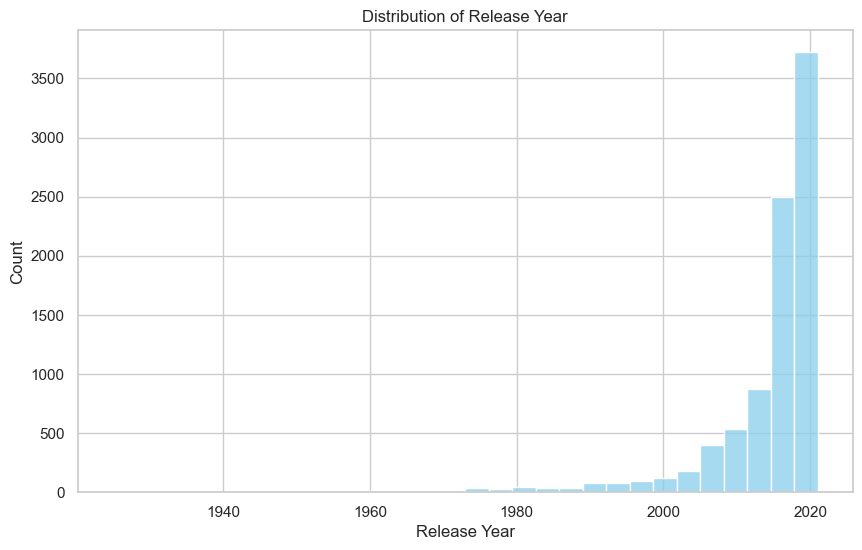

/var/folders/6b/wdmg3d055gvf6774f8z6v4y40000gn/T/ipykernel_13289/548589992.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='viridis')


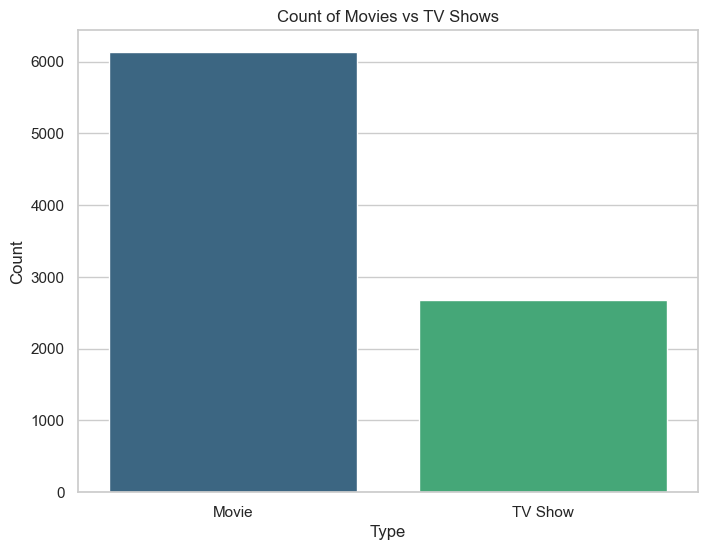

/var/folders/6b/wdmg3d055gvf6774f8z6v4y40000gn/T/ipykernel_13289/548589992.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, order=rating_order, palette='magma')


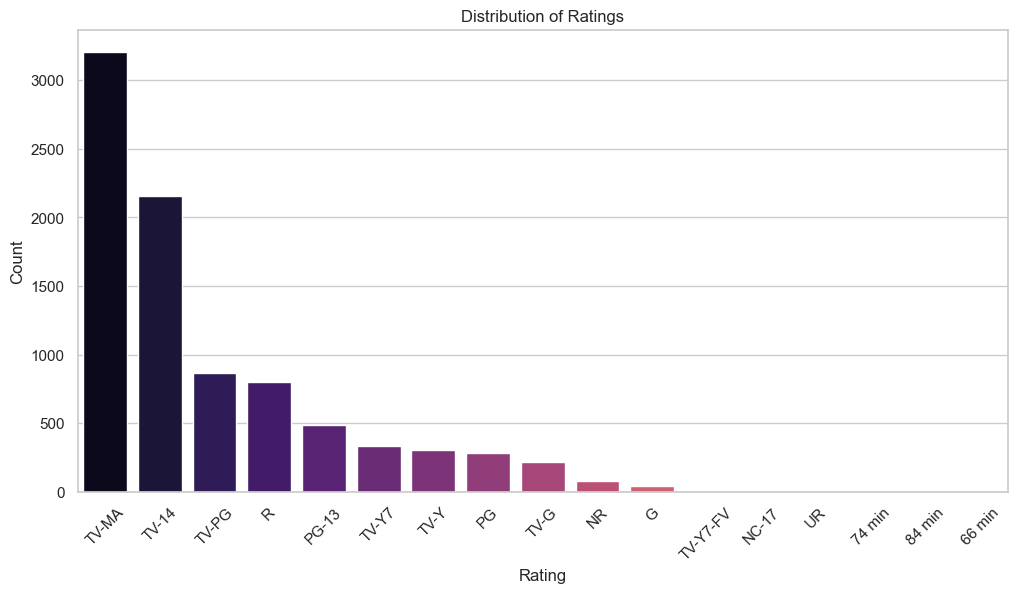

/var/folders/6b/wdmg3d055gvf6774f8z6v4y40000gn/T/ipykernel_13289/548589992.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='coolwarm')


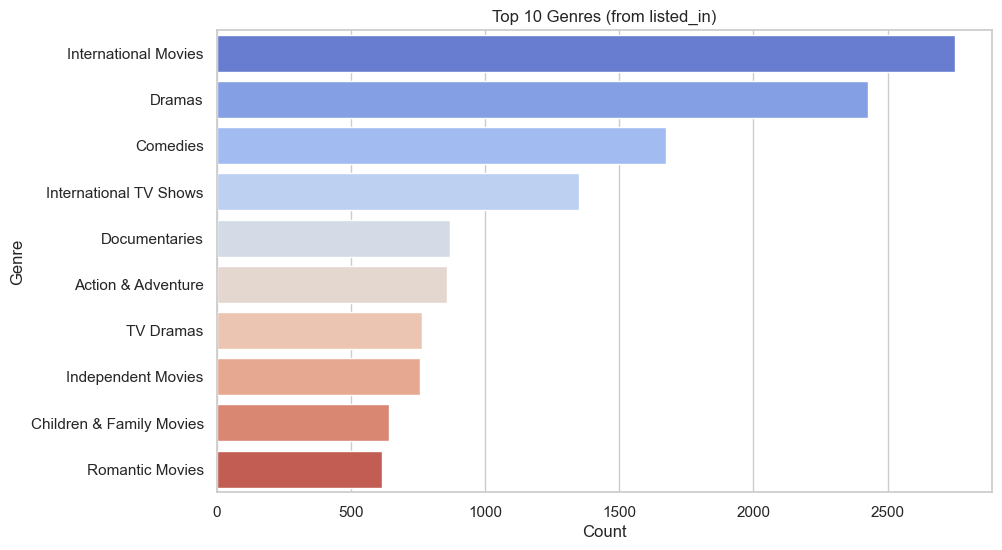

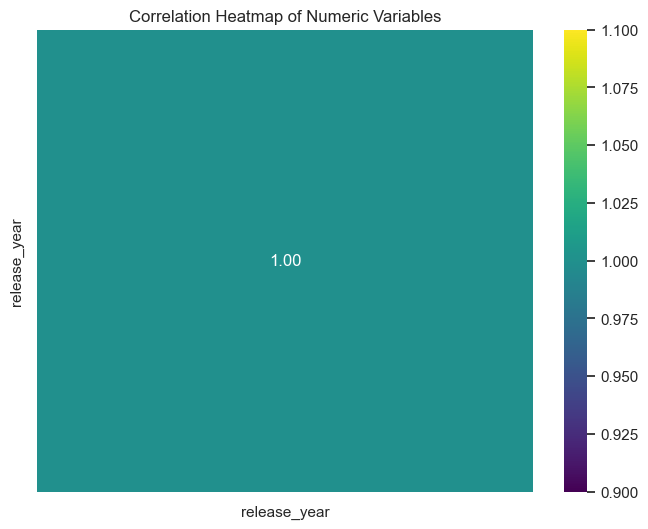

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# 1. Load the Netflix dataset
df = pd.read_csv('netflix_titles.csv')

# Display basic information about the dataset
print("Dataset Information:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# 2. Visualize the distribution of release_year (Numeric Variable)
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'].dropna(), bins=30, kde=False, color='skyblue')
plt.title('Distribution of Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

# 3. Visualize count of Movies vs. TV Shows (Categorical Variable)
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=df, palette='viridis')
plt.title('Count of Movies vs TV Shows')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# 4. Visualize the distribution of rating (Categorical Variable)
plt.figure(figsize=(12, 6))
# Order the ratings by their frequency
rating_order = df['rating'].value_counts().index
sns.countplot(x='rating', data=df, order=rating_order, palette='magma')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 5. Visualize the top 10 genres from the "listed_in" column
# The "listed_in" column contains comma separated genres. We split and "explode" it.
genre_series = df['listed_in'].str.split(',').explode().str.strip()
genre_counts = genre_series.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='coolwarm')
plt.title('Top 10 Genres (from listed_in)')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# (Optional) 6. Visualize a correlation heatmap for the numeric variables.
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
if not numeric_cols.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap='viridis', fmt=".2f")
    plt.title('Correlation Heatmap of Numeric Variables')
    plt.show()


In [ ]:
# Code snippet in the report

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type')
plt.title('Distribution of Movies vs. TV Shows')
plt.show()

In [ ]:
# Week 5: AI Model Development

# Recommender system 
# https://github.com/rcz7795/Movie-Recommendation-System/blob/main/Movie_Recommendation_System.ipynb

In [32]:
import warnings
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

# 1. Load and preprocess the Netflix dataset
df = pd.read_csv('netflix_titles.csv')
df['listed_in'] = df['listed_in'].fillna('')         # Handle missing genre information
df['description'] = df['description'].fillna('')       # Handle missing descriptions
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')  # Ensure release_year is numeric

# Create an enriched feature column by combining genres and description
df['combined_features'] = df['listed_in'] + " " + df['description']

# 2. Build the TF-IDF vectorizer on the enriched feature column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# 3. Define the recommendation function
def enhanced_recommend(query, top_n=10):
    """
    Given a free-text query, this function:
      - Transforms the query into TF-IDF space.
      - Computes cosine similarity against the enriched features.
      - Sorts recommendations by release year (most recent first).
      - Groups the recommendations by year and randomly selects one recommendation per group.
      - Returns up to top_n recommendations from distinct years.
    """
    query_vec = tfidf.transform([query])
    cosine_similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get indices sorted by similarity (highest first)
    indices = cosine_similarities.argsort()[::-1]

    # Retrieve recommendations and sort by release_year descending
    recommendations = df.iloc[indices]
    recommendations_sorted = recommendations.sort_values(by="release_year", ascending=False)
    
    # Suppress the deprecation warning for groupby.apply on the grouping columns.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        diversified = recommendations_sorted.groupby("release_year", group_keys=False).apply(lambda x: x.sample(1))
    
    # Sort the diversified set again by release_year descending
    diversified_sorted = diversified.sort_values(by="release_year", ascending=False)
    
    # Return up to top_n recommendations (one per distinct year)
    return diversified_sorted.head(top_n)

# 4. Function to get a validated yes/no answer from the user
def get_yes_no(prompt):
    while True:
        answer = input(prompt).strip().lower()
        if answer in ['yes', 'y', 'no', 'n']:
            return answer
        print("Please answer with 'yes' or 'no'.")

# 5. Main interactive loop for user input and output
def main():
    print("Welcome to the Netflix Recommender System!")
    print("You can type a description of what kind of movies you want to watch.")
    print("Type 'exit' at any time to quit the application.\n")

    while True:
        user_query = input("What kind of movies do you want to watch? ")
        if user_query.strip().lower() == "exit":
            print("Thank you! Enjoy your movie!")
            break

        if not user_query.strip():
            print("Please enter a valid query.")
            continue

        recommendations = enhanced_recommend(user_query, top_n=10)
        if recommendations.empty:
            print("\nNo recommendations found based on that query.\n")
        else:
            # Build the output table with extra details: Title, Genres, Director, Country, Duration, and Year.
            table_data = recommendations[['title', 'listed_in', 'director', 'country', 'duration', 'release_year']].rename(
                columns={
                    'title': 'Title',
                    'listed_in': 'Genres',
                    'director': 'Director',
                    'country': 'Country',
                    'duration': 'Duration',
                    'release_year': 'Year'
                }
            )
            print("\nTop 10 Recommendations (one per year):\n")
            print(tabulate(table_data, headers='keys', tablefmt='pretty', showindex=False))
        
        cont = get_yes_no("\nIs there anything else you like to watch? (yes/no): ")
        if cont in ['no', 'n']:
            print("Thank you! Enjoy your movie!")
            break

if __name__ == "__main__":
    main()


Welcome to the Netflix Recommender System!
You can type a description of what kind of movies you want to watch.
Type 'exit' at any time to quit the application.



What kind of movies do you want to watch?  crime



Top 10 Recommendations (one per year):

+--------------------------------------+-------------------------------------------------------+------------------+---------------+-----------+------+
|                Title                 |                        Genres                         |     Director     |    Country    | Duration  | Year |
+--------------------------------------+-------------------------------------------------------+------------------+---------------+-----------+------+
| Emicida: AmarElo - Live in São Paulo | Documentaries, International Movies, Music & Musicals | Fred Ouro Preto  |      nan      |  100 min  | 2021 |
|            Masaba Masaba             |    International TV Shows, TV Comedies, TV Dramas     |       nan        |     India     | 1 Season  | 2020 |
|                  4L                  |         Comedies, Dramas, Independent Movies          | Gerardo Olivares |     Spain     |  105 min  | 2019 |
|           Hap and Leonard            |             


Is there anything else you like to watch? (yes/no):  yes
What kind of movies do you want to watch?  history



Top 10 Recommendations (one per year):

+----------------------------------------+-------------------------------------------------+------------------+---------------------------------------------------------------------+-----------+------+
|                 Title                  |                     Genres                      |     Director     |                               Country                               | Duration  | Year |
+----------------------------------------+-------------------------------------------------+------------------+---------------------------------------------------------------------+-----------+------+
|               Hit & Run                | TV Action & Adventure, TV Dramas, TV Mysteries  |       nan        |                        Israel, United States                        | 1 Season  | 2021 |
|                 Heidi                  |                    Kids' TV                     |       nan        |                     France, Australia, Germ


Is there anything else you like to watch? (yes/no):  n


Thank you! Enjoy your movie!
